## 1. Setup and Import libraries

In [1]:
# django path
mysite_path = "C:\\Data\\UCL\\@MSc Project\\DB\\mysite\\"

In [2]:
# standard packages
import os
import sys
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import django
from set_django_db import set_django_db
from asgiref.sync import sync_to_async

from IPython.core.display import HTML

%matplotlib inline

In [3]:
# set django models
set_django_db(mysite_path)
from tables_daniel.models import Company, Review

# specifically for Jupyter notebooks
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

In [4]:
# center plots
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical_align: middle;
}
</style>
""")

## 2. Load, merge and filter the datasets

<hr>

**Content**

    2.1 Load companies
    2.2 Load reviews
    2.3 Some useful merges/adds
    2.4 Filter the data from the monitored period between 2018-07-01 and 2020-06-30
    2.5 Filter only the reviews for the companies with at least 10 reviews
    2.6 Add a column concatenating pros & cons
    2.7 Update employee relatioship

### 2.1 Companies

In [5]:
companies = pd.DataFrame(
    list(
        Company
        .objects
        .values('id', 'Company', 'Sector', 'ListedOn')
        .all()
    )
)

companies_id = list(companies.id)

### 2.2 Reviews

In [6]:
reviews = list(
    Review
    .objects
    .values(
        'id', 'Company_id', 'ReviewTitle', 'Rating',
        'JobTitle', 'EmployeeRelationship',
        'Contract', 'Pros', 'Cons',
        'Year', 'Month', 'Day'
    )
    .all()
    .filter(Company_id = company_id) for company_id in companies_id
)

reviews_df = pd.DataFrame(
    sum([list(reviews_i) for reviews_i in reviews],[])
).drop_duplicates()

In [7]:
"""
for i in range(reviews_df.shape[0]):
    row = dict(reviews_df.iloc[i,:])
    
    review = (
        Review
        .objects
        .values('id', 'JobTitle' ,'EmployeeRelationship')
        .get(id=row['id'])
    )
    
    if review['JobTitle'] in ['Former Employee', 'Current Employee']:
        new_jobTitle = review['EmployeeRelationship']
        new_relationship = review['JobTitle']
        
        (Review
         .objects
         .filter(id=row['id'])
         .update(
             JobTitle = new_jobTitle,
             EmployeeRelationship = new_relationship
         )
        )
    else:
        pass
    
    if (i+1)%100==0:
        print(i+1)
"""

"\nfor i in range(reviews_df.shape[0]):\n    row = dict(reviews_df.iloc[i,:])\n    \n    review = (\n        Review\n        .objects\n        .values('id', 'JobTitle' ,'EmployeeRelationship')\n        .get(id=row['id'])\n    )\n    \n    if review['JobTitle'] in ['Former Employee', 'Current Employee']:\n        new_jobTitle = review['EmployeeRelationship']\n        new_relationship = review['JobTitle']\n        \n        (Review\n         .objects\n         .filter(id=row['id'])\n         .update(\n             JobTitle = new_jobTitle,\n             EmployeeRelationship = new_relationship\n         )\n        )\n    else:\n        pass\n    \n    if (i+1)%100==0:\n        print(i+1)\n"

### 2.3 Some useful merges/adds

In [8]:
# add sector and company name
reviews_df = reviews_df.merge(
    companies[['id', 'Company', 'Sector', 'ListedOn']].rename(columns={'id': 'Company_id'}),
    on='Company_id'
)

# add date column used for filtering
reviews_df['Date'] = reviews_df.apply(lambda x: '-'.join(
    [str(x['Year']), str(x['Month']), str(x['Day'])]
    ), axis=1
)

reviews_df

,id,Company_id,ReviewTitle,Rating,JobTitle,EmployeeRelationship,Contract,Pros,Cons,Year,Month,Day,Company,Sector,Date
0,24966,1,Part Time,4.0,Anonymous Employee,Former Employee,part-time,"Friendly colleagues, willing to give you disco...",There are some politics going on (like any oth...,2020,7,1,Adidas,Consumer Cyclical,2020-7-1
1,24967,1,Terrible experience,1.0,Software Engineer,Former Employee,full-time,Some nice welcoming colleagues and benefits (M...,"Really poor culture and collaboration spirit, ...",2020,7,1,Adidas,Consumer Cyclical,2020-7-1
2,24968,1,Top,5.0,Manager/In,Current Employee,full-time,"Work-Life Balance, nice offices, top sport","Global company, long decision making",2020,6,30,Adidas,Consumer Cyclical,2020-6-30
3,24969,1,Sales Assistant,4.0,Sales Assistant,Former Employee,part-time,Staff helpfulPay was goof Staff are respectuful,Might get a little hectic,2020,6,29,Adidas,Consumer Cyclical,2020-6-29
4,24970,1,My experience is too maintain the task and group,2.0,Questions Solving,Former Employee,part-time,My biggest dream is to work with Adidas family,Difficult to maintain but once know easy to ha...,2020,6,28,Adidas,Consumer Cyclical,2020-6-28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403060,81560,649,Review,4.0,Anonymous Employee,Former Employee,full-time,"Work-life balance, great if you have a young f...",Lack of structured career progression,2018,8,27,WPP plc,Communication Services,2018-8-27
403061,81561,649,Engaging Projects,4.0,Senior Project Manager,Former Employee,full-time,"Flexibility, Responsibility, Authority to get ...",Working across agencies is fun but rarely stru...,2018,8,18,WPP plc,Communication Services,2018-8-18
403062,81562,649,Healthcare and 401k are a joke,1.0,Anonymous Employee,Current Employee,full-time,none - 401k match is extremely low,"401k has a tiny match, why bother?Healthcare i...",2018,8,16,WPP plc,Communication Services,2018-8-16
403063,81563,649,Where hacks go to die.,1.0,Anonymous Employee,Former Employee,full-time,Lack of talent is considered a plus.,"Impersonal, low paying, account folk rule the ...",2018,7,17,WPP plc,Communication Services,2018-7-17


In [9]:
def string_to_date(date_str):
    try:
        return datetime.strptime(date_str, '%Y-%m-%d')
    except:
        return datetime.strptime('1800-1-1', '%Y-%m-%d')
    
def string_to_YM(date_str):
    try:
        return datetime.strptime(date_str, '%Y-%m')
    except:
        return datetime.strptime('1800-1-1', '%Y-%m-%d')

reviews_df['Date'] = reviews_df['Date'].apply(lambda x: string_to_date(x))

reviews_df['Year-Month'] = reviews_df.apply(lambda x: string_to_YM('-'.join([str(x['Year']), str(x['Month'])])), axis=1)

### 2.4 Filter the data from the monitored period between 

In [10]:
# further analysis focusing only on the companies with at least 10 reviews in the monitored period
min_date = datetime.strptime('2018-7-1', '%Y-%m-%d')
max_date = datetime.strptime('2020-6-30', '%Y-%m-%d')

reviews_df = pd.DataFrame(
    reviews_df[(reviews_df.Date >= min_date) & (reviews_df.Date <= max_date)]
)

reviews_df

,id,Company_id,ReviewTitle,Rating,JobTitle,EmployeeRelationship,Contract,Pros,Cons,Year,Month,Day,Company,Sector,Date,Year-Month
2,24968,1,Top,5.0,Manager/In,Current Employee,full-time,"Work-Life Balance, nice offices, top sport","Global company, long decision making",2020,6,30,Adidas,Consumer Cyclical,2020-06-30,2020-06-01
3,24969,1,Sales Assistant,4.0,Sales Assistant,Former Employee,part-time,Staff helpfulPay was goof Staff are respectuful,Might get a little hectic,2020,6,29,Adidas,Consumer Cyclical,2020-06-29,2020-06-01
4,24970,1,My experience is too maintain the task and group,2.0,Questions Solving,Former Employee,part-time,My biggest dream is to work with Adidas family,Difficult to maintain but once know easy to ha...,2020,6,28,Adidas,Consumer Cyclical,2020-06-28,2020-06-01
5,24971,1,great job,4.0,Retail Sales Associate,Former Employee,part-time,cool team fun work environment great company,dealing with some difficult customers,2020,6,28,Adidas,Consumer Cyclical,2020-06-28,2020-06-01
6,24972,1,Sales Floor Team lead,3.0,Team Lead,Former Employee,full-time,employee discount 40-60% most items excluding ...,"low paid job, almost much minimum wage to star...",2020,6,27,Adidas,Consumer Cyclical,2020-06-27,2020-06-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403059,81559,649,Don't even consider going there,1.0,Account Director,Former Employee,full-time,- There are some talented and nice people,- Lives up to all the bad stereotypes of agenc...,2018,8,28,WPP plc,Communication Services,2018-08-28,2018-08-01
403060,81560,649,Review,4.0,Anonymous Employee,Former Employee,full-time,"Work-life balance, great if you have a young f...",Lack of structured career progression,2018,8,27,WPP plc,Communication Services,2018-08-27,2018-08-01
403061,81561,649,Engaging Projects,4.0,Senior Project Manager,Former Employee,full-time,"Flexibility, Responsibility, Authority to get ...",Working across agencies is fun but rarely stru...,2018,8,18,WPP plc,Communication Services,2018-08-18,2018-08-01
403062,81562,649,Healthcare and 401k are a joke,1.0,Anonymous Employee,Current Employee,full-time,none - 401k match is extremely low,"401k has a tiny match, why bother?Healthcare i...",2018,8,16,WPP plc,Communication Services,2018-08-16,2018-08-01


### 2.5 Filter only the reviews for companies with at least 10 reviews

In [11]:
# count reviews
reviews_count = (
    reviews_df
    .groupby('Company')
    .Rating
    .count()
)

# filter companies
companies_filtered = list(reviews_count[reviews_count>10].index)

In [12]:
reviews_df = reviews_df[reviews_df.Company.isin(companies_filtered)]

print(
    f"There are {reviews_df.shape[0]:.0f} reviews in total."
)

There are 392408 reviews in total.


### 2.6 Add a column of concatenated pros & cons + their length

In [91]:
reviews_df['Review'] = reviews_df['Pros'] + ' ' + reviews_df['Cons']

reviews_df['ReviewLength'] = reviews_df['Review'].apply(lambda x: len(x))

C:\Users\danie\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\danie\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [92]:
reviews_df.head()

,id,Company_id,ReviewTitle,Rating,JobTitle,EmployeeRelationship,Contract,Pros,Cons,Year,Month,Day,Company,Sector,Date,Year-Month,Review,ReviewLength
2,24968,1,Top,5.0,Manager/In,Current Employee,full-time,"Work-Life Balance, nice offices, top sport","Global company, long decision making",2020,6,30,Adidas,Consumer Cyclical,2020-06-30,2020-06-01,"Work-Life Balance, nice offices, top sport Glo...",79
3,24969,1,Sales Assistant,4.0,Sales Assistant,Former Employee,part-time,Staff helpfulPay was goof Staff are respectuful,Might get a little hectic,2020,6,29,Adidas,Consumer Cyclical,2020-06-29,2020-06-01,Staff helpfulPay was goof Staff are respectufu...,73
4,24970,1,My experience is too maintain the task and group,2.0,Questions Solving,Former Employee,part-time,My biggest dream is to work with Adidas family,Difficult to maintain but once know easy to ha...,2020,6,28,Adidas,Consumer Cyclical,2020-06-28,2020-06-01,My biggest dream is to work with Adidas family...,97
5,24971,1,great job,4.0,Retail Sales Associate,Former Employee,part-time,cool team fun work environment great company,dealing with some difficult customers,2020,6,28,Adidas,Consumer Cyclical,2020-06-28,2020-06-01,cool team fun work environment great company d...,82
6,24972,1,Sales Floor Team lead,3.0,Team Lead,Former Employee,full-time,employee discount 40-60% most items excluding ...,"low paid job, almost much minimum wage to star...",2020,6,27,Adidas,Consumer Cyclical,2020-06-27,2020-06-01,employee discount 40-60% most items excluding ...,396


### 2.7 Update employee relationship

In [ ]:
def update_EmployeeRelationship(x):
    if x not in ['Current Employee', 'Former Employee']:
        return 'Not specified'
    else:
        return x
    
reviews_df['EmployeeRelationship'] = [update_EmployeeRelationship(reviews_df.loc[row, 'EmployeeRelationship']) for row in reviews_df.index]

## 3. Summary statistics

<hr>

**Content**
    
    3.1 Distribution of ratings/reviews over former/current and part/full-time employees
    3.2 Mean, median, standard deviation and quantiles of total reviews per company
    3.3 Mean, meadin, std and quantiles per sectors

In [106]:
# helper quantile/quartile functions

def q1(x):
    return x.quantile(.25)

def q3(x):
    return x.quantile(.75)

def q10(x):
    return x.quantile(.1)

def q90(x):
    return x.quantile(.9)

In [78]:
# Overall rating stats

print(
    reviews_df
    .Rating
    .agg(['mean', 'std', q1, 'median', q3])
)

mean      3.610497
std       1.228502
q1        3.000000
median    4.000000
q3        5.000000
Name: Rating, dtype: float64


In [95]:
# Overall reviews stats

print(
    reviews_df
    .ReviewLength
    .agg(['mean', 'std', q1, 'median', q3])
)

mean      198.459048
std       290.027821
q1         81.000000
median    112.000000
q3        197.000000
Name: ReviewLength, dtype: float64


### 3.1 Distribution of ratings/reviews over former/current and part/full-time employees

In [57]:
print(
    reviews_df
    .groupby('Contract')
    .Rating
    .agg(['count', 'mean', 'std', q1, 'median', q3])
)

            count      mean       std   q1  median   q3
Contract                                               
            18043  3.504683  1.293533  3.0     4.0  5.0
full-time  316117  3.626034  1.234190  3.0     4.0  5.0
part-time   58240  3.558946  1.172597  3.0     4.0  4.0


In [75]:
print(
    reviews_df
    .groupby('EmployeeRelationship')
    .Rating
    .agg(['count', 'mean', 'std', q1, 'median', q3])
)

                       count      mean       std   q1  median   q3
EmployeeRelationship                                              
Current Employee      220135  3.800568  1.155948  3.0     4.0  5.0
Former Employee       154224  3.351580  1.271634  3.0     4.0  4.0
Not specified          18041  3.504628  1.293594  3.0     4.0  5.0


In [93]:
print(
    reviews_df
    .groupby('Contract')
    .ReviewLength
    .agg(['count', 'mean', 'std', q1, 'median', q3])
)

            count        mean         std  q1  median   q3
Contract                                                  
            18051  176.439699  263.855592  76     104  169
full-time  316117  205.192846  300.320423  82     115  204
part-time   58240  168.733826  233.132379  76     103  167


In [94]:
print(
    reviews_df
    .groupby('EmployeeRelationship')
    .ReviewLength
    .agg(['count', 'mean', 'std', q1, 'median', q3])
)

                       count        mean         std  q1  median   q3
EmployeeRelationship                                                 
Current Employee      220135  193.473196  268.526755  81     112  195
Former Employee       154224  208.151915  320.575667  82     114  202
Not specified          18049  176.446063  263.869329  76     104  169


### 3.2 Mean, median, standard deviation and quantiles of total reviews per company

In [107]:
print(
    reviews_df
    .groupby('Company')
    .Rating
    .count()
    .agg(['mean', 'std', q10, q1, 'median', q3, q90])
)   

mean       648.595041
std       1680.993707
q10         39.400000
q1          83.000000
median     214.000000
q3         559.000000
q90       1361.200000
Name: Rating, dtype: float64


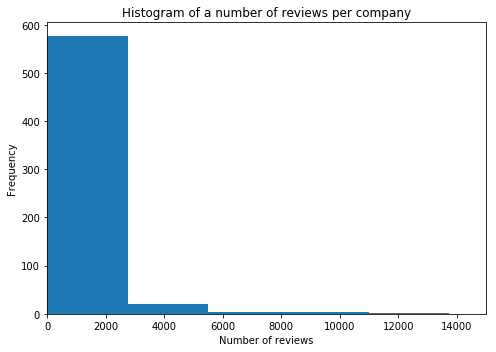

In [103]:
plt.figure(figsize=(7,5))

ax = (reviews_df
 .groupby('Company')
 .Rating
 .count()
 .plot
 .hist()
)

ax.set_xlabel('Number of reviews')
ax.set_title('Histogram of a number of reviews per company')
ax.set_xlim((0, 15000))

plt.tight_layout()

### 3.3 Mean, meadin, std and quantiles per sectors

In [108]:
print(
    reviews_df
    .groupby('Sector')
    .Rating
    .count()
    .agg(['mean', 'std', q10, q1, 'median', q3, q90])
)   

mean      35672.727273
std       32303.327160
q10        3552.000000
q1         5270.000000
median    31891.000000
q3        52074.000000
q90       83958.000000
Name: Rating, dtype: float64


In [51]:
# 1. get number of reviews per company
reviewsPerCompany = (
    reviews_df
    .groupby('Company')
    .Rating
    .count()
)

# 2. assign these values to company_df
companies_filtered_df = companies[companies.Company.isin(companies_filtered)]
companies_filtered_df['TotalReviews'] = reviewsPerCompany

C:\Users\danie\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [53]:
reviewsPerCompany

Company
A.O. Smith Corp            39
ABIOMED Inc                51
AES Corp                   95
AFLAC Inc                 207
AMETEK Inc.                79
                         ... 
Zebra Technologies        142
Zimmer Biomet Holdings    220
Zions Bancorp              95
Zoetis                     88
eBay Inc.                 545
Name: Rating, Length: 605, dtype: int64